In [159]:
import os
import tensorflow
import tensorflow.keras
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Dropout, ReLU, Input, MaxPooling1D
from tensorflow.keras.models import Sequential

import numpy as np

LOAD DATABASES, CONCATENATE AND MIX THEM

In [276]:
path_db_0 = '/scratch/scarpolini/databases/db_lorenz_20.0_27.5.npy'
path_labels_0 = '/scratch/scarpolini/databases/lorenz_labels_20.0_27.5.npy'
path_db_1 = '/scratch/scarpolini/databases/db_lorenz_29.0_50.0.npy'
path_labels_1 = '/scratch/scarpolini/databases/lorenz_labels_29.0_50.0.npy'
path_db_2 = '/scratch/scarpolini/databases/db_lorenz_22.5_26.0.npy'
path_labels_2 = '/scratch/scarpolini/databases/lorenz_labels_22.5_26.0.npy'
path_db_3 = '/scratch/scarpolini/databases/db_lorenz_10.0_50.0.npy'
path_labels_3 = '/scratch/scarpolini/databases/lorenz_labels_10.0_50.0.npy'

db = np.load(path_db_3)
labels = np.load(path_labels_3)

def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

db, labels = unison_shuffled_copies(db, labels)

In [277]:
#devo riadattare i labels ad essere 0 quando il segnale è r=20 e 1 quando r=27.5
new_labels = labels
for label, i in zip(labels, range(len(labels))):
    if label==10:
        new_labels[i] = 0
    elif label==50:
        new_labels[i] = 1
    else: print('problem')
labels = new_labels

PREPROCESSING

In [278]:
#(db_train), (db_test) = db[:80000,:,:], db[80000:,:,:]
# Normalize to between -1 and 1
db = db[:,:,0:1]
print(db.shape)
M = np.max(db)
m = np.min(db)
print(M,m)
db = (db - m)/(M - m)
M = np.max(db)
m = np.min(db)
print(M,m)

#db_train = db_train.reshape(-1, img_rows,img_cols,channels)
#x_train.shape

(100000, 2000, 1)
29.571612147237754 -29.81937884992222
1.0 0.0


VISUALIZE DATA

75044
1.0


IndexError: index 1 is out of bounds for axis 1 with size 1

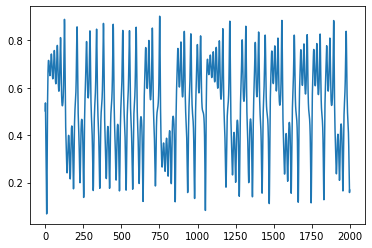

In [279]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np
%matplotlib inline

n = round(np.random.uniform(100000))
#n = 35368
print(n)
traj = db[n,:,:]
print(labels[n])
plt.plot(traj[:,0])
plt.plot(traj[:,1])
plt.plot(traj[:,2])
plt.show()

#fig = plt.figure()
#ax = plt.axes(projection='3d')
#ax.plot3D(traj[:,0],traj[:,1],traj[:,2])

ARCHITETTURA RETE NEURALE

In [6]:
#fs = 3 # dimensione filtro
#fm = 128 # numero filtri
#optimizer = Adam(0.0002, 0.5)
#noise_dim = 100
#sig_len, channels = len(db[0,:,0]), len(db[0,0,:])
#print(sig_len, channels)
#init_sigma = 0.02
#batch_size = 16
#steps_per_epoch = 3750 # 60000 / 16
#epochs = 20

#save_path = 'gan-images'
#if save_path != None and not os.path.isdir(save_path):
#    os.mkdir(save_path)    

#def create_desc():
#    discriminator = Sequential()
#    #input:2000x1
#    discriminator.add(Conv1D(fm, fs, padding='same', kernel_initializer=RandomNormal(0, 0.02), input_shape=(sig_len, channels)))    
#    discriminator.add(Conv1D(fm, fs, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
#    discriminator.add(Conv1D(fm, fs, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
#    discriminator.add(MaxPooling1D(pool_size=2, padding='same'))
#    discriminator.add(Dropout(0.2))
#    #1000x128
#    discriminator.add(Conv1D(fm, fs, padding='same', kernel_initializer=RandomNormal(0, 0.02), input_shape=(sig_len, channels)))    
#    discriminator.add(Conv1D(fm, fs, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
#    discriminator.add(Conv1D(fm, fs, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
#    discriminator.add(MaxPooling1D(pool_size=2, padding='same'))
#    discriminator.add(Dropout(0.2))
#    #500x128
#    discriminator.add(Conv1D(fm, fs, padding='same', kernel_initializer=RandomNormal(0, 0.02), input_shape=(sig_len, channels)))    
#    discriminator.add(Conv1D(fm, fs, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
#    discriminator.add(Conv1D(fm, fs, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
#    discriminator.add(MaxPooling1D(pool_size=2, padding='same'))
#    discriminator.add(Dropout(0.2))
#    #250x128
#    discriminator.add(Conv1D(fm, fs, padding='same', kernel_initializer=RandomNormal(0, 0.02), input_shape=(sig_len, channels)))    
#    discriminator.add(Conv1D(fm, fs, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
#    discriminator.add(Conv1D(fm, fs, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
#    discriminator.add(MaxPooling1D(pool_size=2, padding='same'))
#    discriminator.add(Dropout(0.2))
#    #125x128
#    discriminator.add(Flatten())
#    #16000x1
#    discriminator.add(Dense(128, activation='relu'))
#    #128x1
#    discriminator.add(Dense(1))
#    #1x1
#    discriminator.compile(loss='mean_squared_error', optimizer='sgd')
#    return discriminator


In [265]:
optimizer = Adam(0.0002, 0.5)
sig_len, channels = len(db[0,:,0]), len(db[0,0,:])
fs = 10 # dimensione filtro
fm = 32 # numero filtri
init_sigma = 0.02 # varianza distribuzione parametri iniziali dei kernel
def create_desc():
    discriminator = Sequential()
    #input:2000x1
    discriminator.add(Conv1D(fm, fs, strides=4, padding='same', activation='relu', kernel_initializer=RandomNormal(0, 0.02), input_shape=(sig_len, channels)))    
    discriminator.add(Dropout(0.1))
    #input:500x32
    discriminator.add(Conv1D(fm, fs, strides=2, padding='same', activation='relu', kernel_initializer=RandomNormal(0, 0.02)))    
    discriminator.add(Dropout(0.1))
    #input:250x32
    #discriminator.add(Conv1D(fm, fs, strides=1, padding='same', activation='relu', kernel_initializer=RandomNormal(0, 0.02)))    
    #input:250x64
    discriminator.add(Flatten())
    #8000x1
    discriminator.add(Dense(250*fm, activation='relu'))
    #discriminator.add(Dropout(0.1))
    discriminator.add(Dense(2, activation='softmax'))
    #discriminator.add(Dropout(0.1))
    #4x1
    discriminator.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
    return discriminator

desc = create_desc()

In [259]:
desc.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_29 (Conv1D)           (None, 500, 32)           992       
_________________________________________________________________
dropout_28 (Dropout)         (None, 500, 32)           0         
_________________________________________________________________
conv1d_30 (Conv1D)           (None, 250, 32)           10272     
_________________________________________________________________
dropout_29 (Dropout)         (None, 250, 32)           0         
_________________________________________________________________
flatten_14 (Flatten)         (None, 8000)              0         
_________________________________________________________________
dense_28 (Dense)             (None, 8000)              64008000  
_________________________________________________________________
dense_29 (Dense)             (None, 2)               

TRAINING

In [266]:
#desc = create_desc()
class LossHistory(tensorflow.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
    
    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

history = LossHistory()
fit_history = desc.fit(db, labels, batch_size=256, epochs=20, verbose=1, validation_split=0.33,
                       shuffle=False, callbacks=[history])

Train on 67000 samples, validate on 33000 samples
Epoch 1/20
67000/67000 [==============================] - 7s 101us/sample - loss: 0.6920 - acc: 0.5063 - val_loss: 0.5824 - val_acc: 0.7147
Epoch 2/20
67000/67000 [==============================] - 6s 96us/sample - loss: 0.1816 - acc: 0.9353 - val_loss: 0.0412 - val_acc: 0.9908
Epoch 3/20
67000/67000 [==============================] - 6s 96us/sample - loss: 0.0309 - acc: 0.9935 - val_loss: 0.0211 - val_acc: 0.9955
Epoch 4/20
67000/67000 [==============================] - 6s 90us/sample - loss: 0.1388 - acc: 0.9532 - val_loss: 0.0544 - val_acc: 0.9851
Epoch 5/20
67000/67000 [==============================] - 6s 88us/sample - loss: 0.0341 - acc: 0.9920 - val_loss: 0.0184 - val_acc: 0.9963
Epoch 6/20
67000/67000 [==============================] - 6s 90us/sample - loss: 0.0203 - acc: 0.9960 - val_loss: 0.0167 - val_acc: 0.9967
Epoch 7/20
67000/67000 [==============================] - 6s 88us/sample - loss: 0.0186 - acc: 0.9965 - val_loss: 0

In [267]:
#desc.save('classificatore_binario_20epoche_difficile.h5')
from tensorflow.keras.models import load_model
desc = load_model('classificatore_binario.h5')

TESTING

In [280]:
#n = round(np.random.uniform(0,10000))
desc.evaluate(db,labels)
#output = desc.predict(db[n:n+1000])
#for i in range(100):
#    print(f'{n+i:4}',end="\t")
#    print(f'{output[i][0]:1.2g}',end="\t")
#    print(f'{output[i][1]:1.2g}',end="\t")
#    print(f'{labels[n+i]:3}')

100000/100000 [==============================] - 6s 60us/sample - loss: 0.0028 - acc: 1.0000


[0.002768268127478659, 0.99999]

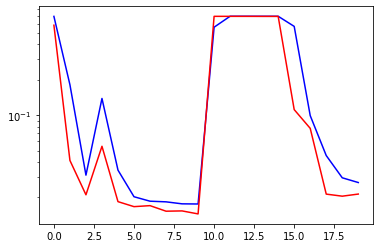

In [268]:
import matplotlib.pyplot as plt
#fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10,10))
#epoch = fit_history.history
epoch = fit_history.history
plt.yscale('log')
plt.plot(epoch['loss'], color="b")
plt.plot(epoch['val_loss'], color="r")
ax2.plot(epoch['acc'], color="b")
ax2.plot(epoch['val_acc'], color="r")

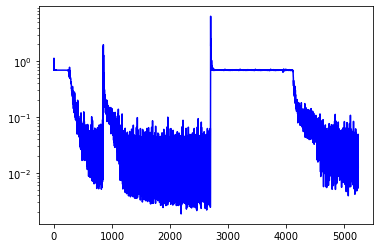

In [269]:
#fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10,10))
#epoch = fit_history.history
losses = history.losses
val_losses = history.val_losses
plt.yscale('log')
plt.plot(losses, color="b")
plt.plot(val_losses, color="r")
#ax2.plot(epoch['acc'], color="b")
#ax2.plot(epoch['val_acc'], color="r")

TypeError: solve_ivp() missing 3 required positional arguments: 'fun', 't_span', and 'y0'